# Предсказание успешности стартапов 

Поставлена задача построить модель машинного обучения для бинарной классификации, которая сможет предсказать успешность стартапов. Представлены данные в датасетах за 1977 по 2015 годы.

___

В датасетах представлены колонки:
- name: Название компании.
- category_list: Категории, к которым относится компания.
- funding_total_usd: Общая сумма привлеченных инвестиций в долларах США.
- status: Текущий статус компании.
- country_code: Код страны регистрации компании.
- state_code: Код штата или региона.
- region: Регион регистрации компании.
- city: Город регистрации компании.
- funding_rounds: Общее количество раундов финансирования.
- founded_at: Дата основания компании.
- first_funding_at: Дата первого раунда финансирования.
- last_funding_at: Дата последнего раунда финансирования.
- closed_at: Дата закрытия компании.
- lifetime: Длительность работы компании в днях.

___

Задачи и цели:
 - Загрузить библиотеки и данные
 - Провести предобработку
 - Проанализировать целевой признак и числовые данные на аномалии, выбрать оптимальную метрику
 - Построить матрицу корреляции и проверить признаки на мультиколлинеарность
 - Построить модель без и с синтетическими признаками
 - Сделать выводы

## Разведовательный анализ и загрузка библиотек

In [1]:
!pip install phik
!pip install xgboost
!pip install catboost

import pandas as pd
import numpy as np
from phik.report import plot_correlation_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
#Загрузим данные
train_df = pd.read_csv('kaggle_startups_train_28062024.csv')
test_df = pd.read_csv('kaggle_startups_test_28062024.csv')
names_df = pd.read_csv('kaggle_startups_sample_submit_28062024.csv')

In [3]:
#функция для разведки
def analyze_dataframe(df, name):
    display(df.head())
    print()
    df.info()
    print()
    print(df.dtypes)

analyze_dataframe(train_df, "train_df")

,name,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,closed_at
0,Lunchgate,Online Reservations|Restaurants,828626.00,operating,CHE,25,Zurich,Zürich,2,2009-10-17,2011-05-01,2014-12-01,NaN
1,EarLens,Manufacturing|Medical|Medical Devices,42935019.00,operating,USA,CA,SF Bay Area,Redwood City,4,2005-01-01,2010-05-04,2014-02-25,NaN
2,Reviva Pharmaceuticals,Biotechnology,35456381.00,operating,USA,CA,SF Bay Area,San Jose,3,2006-01-01,2012-08-20,2014-07-02,NaN
3,Sancilio and Company,Health Care,22250000.00,operating,NaN,NaN,NaN,NaN,3,2004-01-01,2011-09-01,2014-07-18,NaN
4,WireTough Cylinders,Manufacturing,NaN,operating,USA,VA,VA - Other,Bristol,1,2010-05-12,2012-02-01,2012-02-01,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52516 entries, 0 to 52515
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               52515 non-null  object 
 1   category_list      50051 non-null  object 
 2   funding_total_usd  42447 non-null  float64
 3   status             52516 non-null  object 
 4   country_code       47014 non-null  object 
 5   state_code         45753 non-null  object 
 6   region             46157 non-null  object 
 7   city               46157 non-null  object 
 8   funding_rounds     52516 non-null  int64  
 9   founded_at         52516 non-null  object 
 10  first_funding_at   52516 non-null  object 
 11  last_funding_at    52516 non-null  object 
 12  closed_at          4917 non-null   object 
dtypes: float64(1), int64(1), object(11)
memory usage: 5.2+ MB

name                  object
category_list         object
funding_total_usd    float64
status             

In [4]:
analyze_dataframe(test_df, "test_df")

,name,category_list,funding_total_usd,country_code,state_code,region,city,funding_rounds,first_funding_at,last_funding_at,lifetime
0,Crystalsol,Clean Technology,2819200.00,NIC,17,NaN,NaN,1,2009-07-01,2009-07-01,3501
1,JBI Fish & Wings,Hospitality,NaN,USA,TN,TN - Other,Humboldt,1,2010-07-28,2010-07-28,2717
2,COINPLUS,Finance,428257.00,LUX,3,Esch-sur-alzette,Esch-sur-alzette,2,2014-05-15,2014-09-18,1295
3,Imagine Communications,Software|Video|Video Streaming,34700000.00,USA,CA,San Diego,San Diego,4,2005-01-01,2010-04-20,4748
4,DNA13,Software,4530000.00,CAN,ON,Ottawa,Ottawa,1,2007-05-08,2007-05-08,6209



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               13125 non-null  object 
 1   category_list      12534 non-null  object 
 2   funding_total_usd  10547 non-null  float64
 3   country_code       11743 non-null  object 
 4   state_code         11430 non-null  object 
 5   region             11536 non-null  object 
 6   city               11538 non-null  object 
 7   funding_rounds     13125 non-null  int64  
 8   first_funding_at   13125 non-null  object 
 9   last_funding_at    13125 non-null  object 
 10  lifetime           13125 non-null  int64  
dtypes: float64(1), int64(2), object(8)
memory usage: 1.1+ MB

name                  object
category_list         object
funding_total_usd    float64
country_code          object
state_code            object
region                object
city                  object


In [5]:
analyze_dataframe(names_df, "names_df")

,name,status
0,Crystalsol,closed
1,JBI Fish & Wings,operating
2,COINPLUS,closed
3,Imagine Communications,closed
4,DNA13,operating



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13125 entries, 0 to 13124
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    13125 non-null  object
 1   status  13125 non-null  object
dtypes: object(2)
memory usage: 205.2+ KB

name      object
status    object
dtype: object


In [6]:
test_df = test_df.merge(names_df[['name', 'status']], on='name', how='left')

# Проверим, успешно ли добавился статус
print(test_df.head())
print(test_df['status'].isnull().sum(), " строк с пустыми значениями в 'status'")

                     name                   category_list  funding_total_usd  \
0              Crystalsol                Clean Technology         2819200.00   
1        JBI Fish & Wings                     Hospitality                NaN   
2                COINPLUS                         Finance          428257.00   
3  Imagine Communications  Software|Video|Video Streaming        34700000.00   
4                   DNA13                        Software         4530000.00   

  country_code state_code            region              city  funding_rounds  \
0          NIC         17               NaN               NaN               1   
1          USA         TN        TN - Other          Humboldt               1   
2          LUX          3  Esch-sur-alzette  Esch-sur-alzette               2   
3          USA         CA         San Diego         San Diego               4   
4          CAN         ON            Ottawa            Ottawa               1   

  first_funding_at last_funding_

Выводы:

- Загружены три набора данных: тренировочная выборка, тестовая выборка и дополнительный датасет для анализа
Различия в категориях и столбцах:

- Есть несоответствия в составах столбцов и категориях между тренировочной и тестовой выборками

- В данных есть пропущенные значения, которые необходимо обработать

- Типы данных в большинстве столбцов соответствуют ожидаемым, кроме столбцов с датами

- Объединили тестовую выборки и датафрем с статусами стартапов

## Предобработка

In [7]:
#Меняем типы у дат
train_df['founded_at'] = pd.to_datetime(train_df['founded_at'], errors='coerce')
train_df['first_funding_at'] = pd.to_datetime(train_df['first_funding_at'], errors='coerce')
train_df['last_funding_at'] = pd.to_datetime(train_df['last_funding_at'], errors='coerce')
train_df['closed_at'] = pd.to_datetime(train_df['closed_at'], errors='coerce')

test_df['first_funding_at'] = pd.to_datetime(test_df['first_funding_at'], errors='coerce')
test_df['last_funding_at'] = pd.to_datetime(test_df['last_funding_at'], errors='coerce')

In [8]:
#Создадим список с датафремами, чтобы было проще
dataframes = {
    "train_df": train_df,
    "test_df": test_df}

#Смотрим пропуски 
missing_counts = {name: df.isnull().sum() for name, df in dataframes.items()}
for name, counts in missing_counts.items():
    print(f"Пропуски в {name}:\n{counts}")
    print()

Пропуски в train_df:
name                     1
category_list         2465
funding_total_usd    10069
status                   0
country_code          5502
state_code            6763
region                6359
city                  6359
funding_rounds           0
founded_at               0
first_funding_at         0
last_funding_at          0
closed_at            47599
dtype: int64

Пропуски в test_df:
name                    0
category_list         591
funding_total_usd    2578
country_code         1382
state_code           1695
region               1589
city                 1587
funding_rounds          0
first_funding_at        0
last_funding_at         0
lifetime                0
status                  0
dtype: int64



In [9]:
#Смотрим дубли
duplicates_counts = {name: df.duplicated().sum() for name, df in dataframes.items()}
for name, count in duplicates_counts.items():
    print(f"Очевидные дубли в {name}: {count}")
    print()

Очевидные дубли в train_df: 0

Очевидные дубли в test_df: 0



In [10]:
#Проверим неочевидные дубли по уникальному признаку
for df in [train_df, test_df, names_df]:
    df['name'] = df['name'].str.lower()

duplicates_info = {}

#Проверяем на дубли
for name, df in zip(['train_df', 'test_df', 'names_df'], [train_df, test_df, names_df]):
    duplicates_count = df['name'].duplicated().sum()
    duplicates_info[name] = {
        'count': duplicates_count,
        'duplicates': df[df.duplicated(subset='name', keep=False)]}

#Сравним дубли и проверим являются ли они дублями
train_duplicates_comparison = duplicates_info['train_df']['duplicates'][['name', 'category_list', 'funding_total_usd',
                                                                         'status', 'country_code',
                                                                         'state_code', 'funding_rounds']].sort_values(by='name').head(10)
test_duplicates_comparison = duplicates_info['test_df']['duplicates'][['name', 'category_list', 'funding_total_usd',
                                                                       'country_code', 'state_code',
                                                                       'funding_rounds']].sort_values(by='name').head(10)

train_duplicates_comparison, test_duplicates_comparison

(          name                     category_list  funding_total_usd  \
 46394    alike                       Curated Web           25000.00   
 7330     alike                            Design                NaN   
 46996  artsper                               Art         1684764.31   
 3250   artsper  Art|E-Commerce|Marketplaces|SaaS          413177.00   
 16032  beeline                               NaN                NaN   
 9006   beeline                          Software           75000.00   
 26422     beme                        E-Commerce         2619242.00   
 16073     beme                             Video         2000000.00   
 36847    blinq                              Apps          100000.00   
 21401    blinq        Online Dating|Social Media         1000000.00   
 
           status country_code state_code  funding_rounds  
 46394  operating          USA         WA               1  
 7330      closed          FRA         A8               1  
 46996  operating         

Оставим дубликаты по названию, скорее всего это разные стартапы, просто с одниаковыми названиями

In [11]:
#Посмотрим на частоту распредления, может будет идея как заполнить пропуски
country_state_distribution = train_df[['country_code', 'state_code']].value_counts(dropna=False).head(10)

missing_state_by_country = train_df['country_code'][train_df['state_code'].isnull()].value_counts()

country_state_distribution, missing_state_by_country

(country_code  state_code
 USA           CA            10219
 NaN           NaN            5502
 USA           NY             3112
               MA             2020
               TX             1562
 GBR           H9             1510
 USA           FL             1038
               WA              997
               IL              859
               PA              795
 Name: count, dtype: int64,
 country_code
 SGP    356
 HKG    162
 CHN    115
 ISR     84
 GBR     83
       ... 
 ARG      1
 BLM      1
 NGA      1
 PSE      1
 ZMB      1
 Name: count, Length: 76, dtype: int64)

In [12]:
#Очевидных идей не появилось, заменим все заглушками
fill_values = {
    'state_code': 'UNKNOWN_STATE',
    'country_code': 'UNKNOWN_COUNTRY',
    'region': 'UNKNOWN_REGION',
    'city': 'UNKNOWN_CITY'
}

#Заполним пропуски заглушками
for column, fill_value in fill_values.items():
    train_df[column] = train_df[column].fillna(fill_value)
    test_df[column] = test_df[column].fillna(fill_value)

In [13]:
#Выберем last_fundig_at как максимальное значение для подсчета lifetime в тренировочной и преобразуем данные для рассчетов
max_last_funding_date = pd.to_datetime(train_df['last_funding_at']).max()

train_df[['founded_at', 'closed_at']] = train_df[['founded_at', 'closed_at']].apply(pd.to_datetime, errors='coerce')

train_df['lifetime'] = (train_df['closed_at'].fillna(max_last_funding_date) - train_df['founded_at']).dt.days


#Посмотрим что получилось
train_df[['name', 'founded_at', 'last_funding_at', 'lifetime']].head()


,name,founded_at,last_funding_at,lifetime
0,lunchgate,2009-10-17,2014-12-01,2242
1,earlens,2005-01-01,2014-02-25,3992
2,reviva pharmaceuticals,2006-01-01,2014-07-02,3627
3,sancilio and company,2004-01-01,2014-07-18,4358
4,wiretough cylinders,2010-05-12,2012-02-01,2035


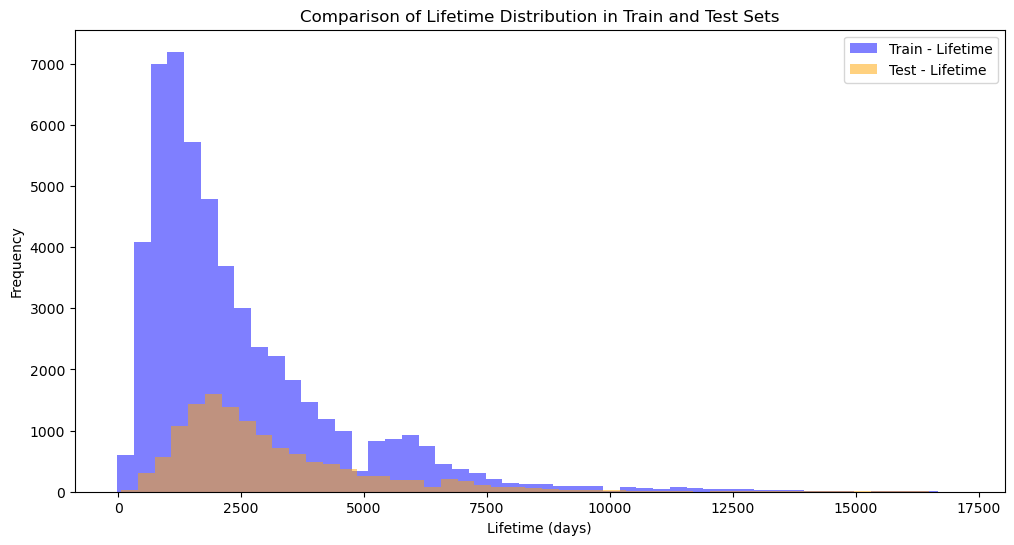

In [14]:
#Посмотрим в целом как распределено lifetime
plt.figure(figsize=(12, 6))
plt.hist(train_df['lifetime'], bins=50, alpha=0.5, label='Train - Lifetime', color='blue')
plt.hist(test_df['lifetime'], bins=50, alpha=0.5, label='Test - Lifetime', color='orange')
plt.xlabel('Lifetime (days)')
plt.ylabel('Frequency')
plt.title('Comparison of Lifetime Distribution in Train and Test Sets')
plt.legend()
plt.show()

Судя по графику мы очень похоже сгенерировали lifetime для тренировочной выборки, распредление похоже на распределение в тестовой, можно удалить closed_at из тренировочной выборки 

In [15]:
#Удаляем ненуджный признак
train_df.drop(columns=['closed_at'], inplace=True)

In [16]:
#Большое количество категорий проверим на уникальность и определим в другие категории по словарю
all_categories_series = pd.Series(
    [cat for sublist in train_df['category_list'].fillna('').str.lower().str.split('|') for cat in sublist])

# Подсчитываем частоту категорий
category_counts = all_categories_series.value_counts()

# Общее количество уникальных значений
total_unique_categories = category_counts.nunique()
print(f"Общее количество уникальных категорий: {total_unique_categories}")

# Категории с частотой более 100
high_frequency_categories = category_counts[category_counts >500]
print("\nКатегории с частотой более 100:")
print(high_frequency_categories)

Общее количество уникальных категорий: 267

Категории с частотой более 100:
software                  7017
mobile                    4399
biotechnology             3668
e-commerce                3308
                          2465
curated web               2407
social media              2284
enterprise software       2193
advertising               1985
health care               1885
games                     1810
internet                  1663
saas                      1595
health and wellness       1513
education                 1491
analytics                 1477
apps                      1468
finance                   1455
technology                1441
clean technology          1226
hardware + software       1171
services                  1136
manufacturing             1080
medical                    951
marketplaces               890
security                   870
video                      866
fashion                    832
big data                   746
entertainment            

Решено обхединить огромное количество категорий в более общие группы, чтобы сократить вариативность. В прочую категорию отнесем редковстречающиеся варианты. Мы снизим размерность и избавимся от лишних шумов в данных, так модель проще распонзнает закономерности. Возможный минус - дисбаланс классов

In [17]:
#Присвоим категории
def categorize_group(category_list):
    if pd.isna(category_list):
        return 'miscellaneous'
    
    category_list = category_list.lower().split('|')
    
    if any(cat in category_list for cat in ['software', 'enterprise software', 'saas', 'apps', 'analytics', 'internet', 'technology', 'cloud computing']):
        return 'tech_innovations'
    elif any(cat in category_list for cat in ['biotechnology', 'health care', 'health and wellness', 'medical devices', 'medical', 'pharmaceutical']):
        return 'health_biotech'
    elif any(cat in category_list for cat in ['social media', 'curated web', 'advertising', 'social network media', 'messaging', 'networking']):
        return 'digital_social'
    elif any(cat in category_list for cat in ['finance', 'financial services', 'fintech']):
        return 'financial_tech'
    elif any(cat in category_list for cat in ['education', 'e-learning']):
        return 'edu_elearning'
    elif any(cat in category_list for cat in ['clean technology', 'environmental', 'green', 'sustainability']):
        return 'sustainable_tech'
    elif any(cat in category_list for cat in ['games', 'entertainment', 'video', 'media', 'music']):
        return 'digital_entertainment'
    elif any(cat in category_list for cat in ['manufacturing', 'hardware', 'industrial', 'semiconductors']):
        return 'industrial_hardware'
    elif any(cat in category_list for cat in ['e-commerce', 'retail', 'marketplaces']):
        return 'ecommerce_retail'
    elif any(cat in category_list for cat in ['consulting', 'services', 'hospitality']):
        return 'consulting_services'
    elif any(cat in category_list for cat in ['travel', 'real estate']):
        return 'lifestyle_travel'
    else:
        return 'miscellaneous'

#Заменим категории
def categorize_and_rename(df, column_name='category_list', new_name='category'):
    df[column_name] = df[column_name].apply(categorize_group)
    df.rename(columns={column_name: new_name}, inplace=True)
    return df[new_name].value_counts()

#Посмотрим что получилось
train_category_counts = categorize_and_rename(train_df)
test_category_counts = categorize_and_rename(test_df)

train_category_counts, test_category_counts



(category
 tech_innovations         14385
 miscellaneous            12913
 health_biotech            6738
 digital_social            5719
 ecommerce_retail          2830
 digital_entertainment     2380
 industrial_hardware       1519
 financial_tech            1501
 consulting_services       1439
 sustainable_tech          1186
 edu_elearning             1018
 lifestyle_travel           888
 Name: count, dtype: int64,
 category
 tech_innovations         3474
 miscellaneous            3255
 health_biotech           1672
 digital_social           1464
 ecommerce_retail          688
 digital_entertainment     597
 industrial_hardware       394
 consulting_services       384
 financial_tech            375
 sustainable_tech          324
 edu_elearning             278
 lifestyle_travel          220
 Name: count, dtype: int64)

Присутствует небольшой дисбаланс классов, посмотрим насколько сильно это будет влиять на модель

In [18]:
#Заполним пустые значения в финансировании медианой по категориям
funding_median_by_category = train_df.groupby('category')['funding_total_usd'].median()
overall_funding_median = train_df['funding_total_usd'].median()

train_df['funding_total_usd'] = train_df['funding_total_usd'].fillna(
    train_df['category'].map(funding_median_by_category).fillna(overall_funding_median))

test_df['funding_total_usd'] = test_df['funding_total_usd'].fillna(
    test_df['category'].map(funding_median_by_category).fillna(overall_funding_median))

train_df.drop(columns=['founded_at'], inplace=True, errors='ignore')
train_df = train_df.dropna(subset=['name'])

In [19]:
train_df.isna().sum()

name                 0
category             0
funding_total_usd    0
status               0
country_code         0
state_code           0
region               0
city                 0
funding_rounds       0
first_funding_at     0
last_funding_at      0
lifetime             0
dtype: int64

In [20]:
test_df.isna().sum()

name                 0
category             0
funding_total_usd    0
country_code         0
state_code           0
region               0
city                 0
funding_rounds       0
first_funding_at     0
last_funding_at      0
lifetime             0
status               0
dtype: int64

Выводы:

- Удалили одну строку в тренировочной выборке, где колонка name содержала пропущенное значение

-  Проверили уникальные значения в категориальных признаках, провели их объединение в более крупные группы, тем самым сократили множество уникальных значений

- Пропуски в колонке, связанной с финансированием, были заполнены медианным значением, рассчитанным по каждой категории

- На основе данных с даты основания и закрытия стартапа в тренировочную выборку добавлен новый признак lifetime

- Пропуски в признаках state_code, country_code, region и city заменены на заглушки, так как оптимального способа заполнения на основе других данных не нашли

- Типы данных в колоснках с датами привели к оптимальному формату

- Провели проверку на очевидные дубликаты

- Удаление дат closed_at и founded_at из тренировочной выборки, эти даты уже использованы для создания признака lifetime

## Анализ распределения признаков

count         52515.00
mean       15141534.10
std       168348383.51
min               1.00
25%          530000.00
50%         1750000.00
75%         7000000.00
max     30079503000.00
Name: funding_total_usd, dtype: float64 



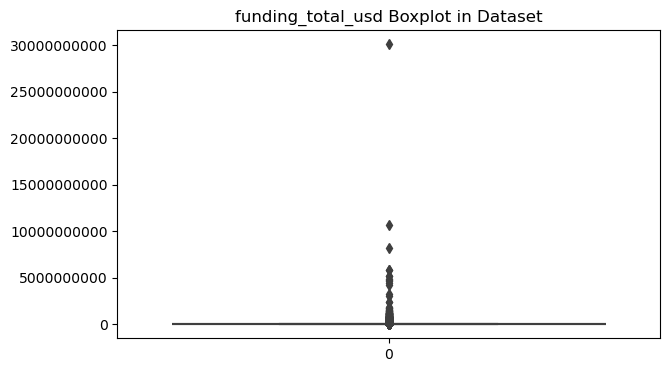

In [21]:
#Фукнкция для просмотра распределения
def analyze_feature_boxplot(df, feature):
    print(df[feature].describe(), "\n")
    
    plt.figure(figsize=(7, 4))
    sns.boxplot(df[feature])
    plt.title(f'{feature} Boxplot in Dataset')
    plt.ticklabel_format(style='plain', axis='y')
    plt.show()

analyze_feature_boxplot(train_df, 'funding_total_usd')

In [22]:
#Удалим выбивающиейся значения и посмотрим сколько удалилось строк
rows_deleted = train_df.shape[0] - train_df[train_df['funding_total_usd'] <= 300000000].shape[0]
train_df = train_df[train_df['funding_total_usd'] <= 300000000]
percent_deleted = (rows_deleted / (rows_deleted + train_df.shape[0])) * 100

print("Удалено строк:", rows_deleted)
print("Процент удаленных строк:", f"{percent_deleted:.2f}%")

Удалено строк: 267
Процент удаленных строк: 0.51%


Судя по графику есть очевидные аномалии, удалим их, судя по распределению данных, потимальным было сделать срез для финансирования не более 300000000. Минимальное финансирование в 1 доллар решено оставить, т.к. не является аномалией. Возможно это символизирует ранние этапы стартапа. Удалено окол половины процента строчек

analyze_feature_boxplot(train_df, 'funding_total_usd')

In [23]:
rows_deleted_test = test_df.shape[0] - test_df[test_df['funding_total_usd'] <= 300000000].shape[0]
test_df = test_df[test_df['funding_total_usd'] <= 300000000]
percent_deleted_test = (rows_deleted_test / (rows_deleted_test + test_df.shape[0])) * 100

print("Удалено строк в тестовой выборке:", rows_deleted_test)
print("Процент удаленных строк в тестовой выборке:", f"{percent_deleted_test:.2f}%")

Удалено строк в тестовой выборке: 62
Процент удаленных строк в тестовой выборке: 0.47%


Аналогично тренировочной выборке, удалено меньше процента строчек

count   52248.00
mean     2446.79
std      2091.13
min       -25.00
25%      1070.00
50%      1801.00
75%      3262.00
max     17004.00
Name: lifetime, dtype: float64 



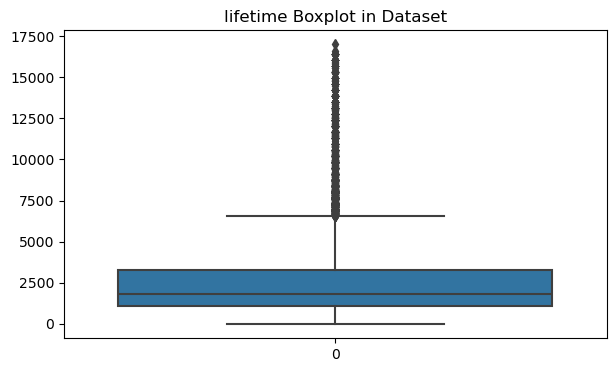

In [24]:
analyze_feature_boxplot(train_df, 'lifetime')

In [25]:
#убираем отрицательные и нулевые значения 
initial_row_count_lifetime = train_df.shape[0]  # Сохраняем исходное количество строк
train_df = train_df[train_df['lifetime'] >= 1]  # Удаляем строки с отрицательными значениями

rows_deleted_lifetime = initial_row_count_lifetime - train_df.shape[0]
percent_deleted_lifetime = (rows_deleted_lifetime / initial_row_count_lifetime) * 100
print("Удалено строк с отрицательным lifetime:", rows_deleted_lifetime)
print("Процент удаленных строк:", f"{percent_deleted_lifetime:.2f}%")

Удалено строк с отрицательным lifetime: 3
Процент удаленных строк: 0.01%


Убрали отрицательное значение стартапов, удалено 3 строчки ситуацию.

count   13063.00
mean     3086.91
std      2112.93
min        52.00
25%      1720.00
50%      2517.00
75%      3837.00
max     16802.00
Name: lifetime, dtype: float64 



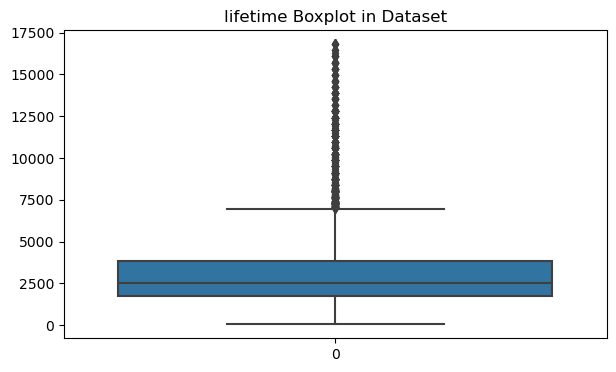

In [26]:
analyze_feature_boxplot(test_df, 'lifetime')

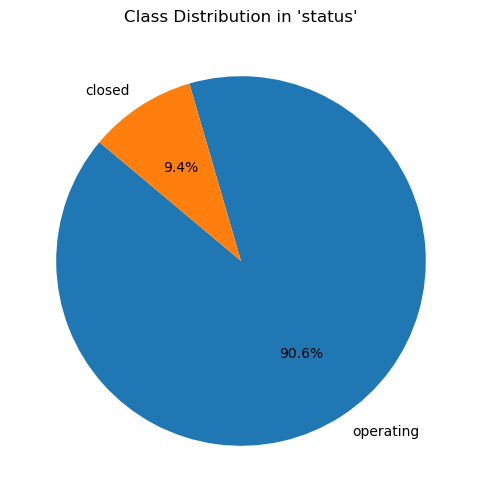

In [27]:
#Посмотрим на распределение целевого признака
status_distribution = train_df['status'].value_counts(normalize=True) * 100

plt.figure(figsize=(6, 6))
plt.pie(status_distribution, labels=status_distribution.index, autopct='%1.1f%%', startangle=140)
plt.title("Class Distribution in 'status'")
plt.show()

Высокий дисбаланс целевого признака, для оценки модели будем испоьзовать f1-меру 

Выводы:

- Проанализировали распределения значений в числовых признаках и выявили аномалии
 - Для финансирования сделали ограничение — 300000000, что привело к удалению 0.51% данных в тренировочной выборке и 0.47% в тестовой
 - Удалили отрицательные значения в lifetime

- Распределение целевого признака сильно дисбалансно, 90.6% у одного класса и 9.4% у другого. В следствии этого будем использовать f1-меру как основную метрику

## Проверка Корреляции 

C:\Users\User\anaconda3\Lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable last_funding_at is large: 1401. Are you sure this is not an interval variable? Analysis for pairs of variables including last_funding_at can be slow.
  warnings.warn(


<Figure size 1000x800 with 0 Axes>

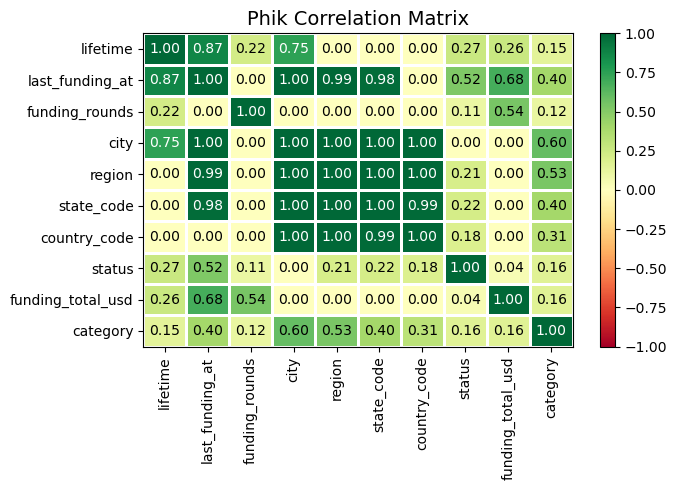

In [28]:
#Данных много, возьмем часть из них, чтобы проверить корреляцию
sampled_df = train_df.sample(frac=0.05, random_state=42)

#Уберем столбцы с датами и именем
sampled_df_reduced = sampled_df.drop(columns=['first_funding_at', 'name'], errors='ignore')

#Считаем и строим phik матрицу
phik_matrix_sampled_reduced = sampled_df_reduced.phik_matrix(interval_cols=['funding_total_usd', 'funding_rounds', 'lifetime'])
plt.figure(figsize=(10, 8))
plot_correlation_matrix(phik_matrix_sampled_reduced.values,
                        x_labels=phik_matrix_sampled_reduced.columns,
                        y_labels=phik_matrix_sampled_reduced.index, title="Phik Correlation Matrix")
plt.show()

In [29]:
#Убераем столбцы с сильной корреляцией 
columns_to_drop = ['region', 'city', 'state_code']

train_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')
test_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')

C:\Users\User\AppData\Local\Temp\ipykernel_5680\3598063022.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.drop(columns=columns_to_drop, inplace=True, errors='ignore')


Выводы:
 - Построена матрица корреляции и провели анализ на мультиколлинеарность

 - Высокая корреляция между признаками region, city и state_code. Скорее всего проблема в наших заглушках
   
 - Принято решение оставить только country_code как наиболее обобщенный признак, удалив region, city и state_code

## Построение моделей

In [30]:
#Подготовка данных 
def prepare_data(train_df, test_df, add_years=False, add_duration=False):
    train_df_model = train_df.copy()
    test_df_model = test_df.copy()
    
    #Для модели с извлеченным годом
    if add_years:
        train_df_model['first_funding_year'] = pd.to_datetime(train_df_model['first_funding_at']).dt.year
        train_df_model['last_funding_year'] = pd.to_datetime(train_df_model['last_funding_at']).dt.year
        test_df_model['first_funding_year'] = pd.to_datetime(test_df_model['first_funding_at']).dt.year
        test_df_model['last_funding_year'] = pd.to_datetime(test_df_model['last_funding_at']).dt.year

    #Для модели с временем финансирования
    if add_duration:
        train_df_model['funding_duration'] = train_df_model['last_funding_year'] - train_df_model['first_funding_year']
        test_df_model['funding_duration'] = test_df_model['last_funding_year'] - test_df_model['first_funding_year']
    
    #Кодировка
    label_encoder = LabelEncoder()
    train_df_model['status'] = label_encoder.fit_transform(train_df_model['status'])
    test_df_model['status'] = label_encoder.transform(test_df_model['status'])
    
    #Удаляем лишнее
    train_df_model.drop(columns=['name', 'first_funding_at', 'last_funding_at'], inplace=True, errors='ignore')
    test_df_model.drop(columns=['name', 'first_funding_at', 'last_funding_at'], inplace=True, errors='ignore')
    
    #Определим категории
    ohe_columns = [col for col in ['country_code', 'category'] if col in train_df_model.columns]
    num_columns = [col for col in ['funding_total_usd', 'funding_rounds', 'lifetime', 
                                   'first_funding_year', 'last_funding_year', 'funding_duration'] 
                   if col in train_df_model.columns]
    
    #Обучаем ohe
    ohe_encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
    ohe_encoder.fit(train_df_model[ohe_columns])
    
    #Преобразуем ohe
    train_ohe = pd.DataFrame(ohe_encoder.transform(train_df_model[ohe_columns]), 
                             columns=ohe_encoder.get_feature_names_out())
    test_ohe = pd.DataFrame(ohe_encoder.transform(test_df_model[ohe_columns]), 
                            columns=ohe_encoder.get_feature_names_out())
    
    #Соеденим данные
    train_df_final = pd.concat([train_df_model.reset_index(drop=True).drop(columns=ohe_columns), train_ohe], axis=1)
    test_df_final = pd.concat([test_df_model.reset_index(drop=True).drop(columns=ohe_columns), test_ohe], axis=1)
    
    return train_df_final, test_df_final

#Функиця для обучения и тестировки модели
def train_and_evaluate_model(train_df, test_df):
    #Пайплайн
    pipe_final = Pipeline([
        ('scaler', 'passthrough'),
        ('models', LogisticRegression(solver='liblinear', random_state=42))
    ])

    #выбор моделей и параметров
    param_grid = [
        {
            'models': [LogisticRegression(solver='liblinear', random_state=42)],
            'models__C': [0.1, 1]
        },
        {
            'models': [RandomForestClassifier(random_state=42, class_weight='balanced')],
            'models__n_estimators': [100, 200],
            'models__max_depth': [5, 10]
        },
        {
            'models': [XGBClassifier(use_label_encoder=False, eval_metric='logloss')],
            'models__learning_rate': [0.1],
            'models__max_depth': [3, 5]
        },
        {
            'models': [CatBoostClassifier(silent=True)],
            'models__learning_rate': [0.1],
            'models__depth': [4, 6]
        },
        {
            'models': [KNeighborsClassifier()],
            'models__n_neighbors': [3, 5],
            'scaler': [StandardScaler(), MinMaxScaler()]  # Масштабируем для KNN
        }
    ]

    #Gridserch
    grid_search = GridSearchCV(pipe_final, param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid_search.fit(train_df.drop(columns=['status']), train_df['status'])
    
    #Выводим результат
    print('Лучшая модель и её параметры:\n', grid_search.best_estimator_)
    
    #Оценка
    y_test_pred = grid_search.predict(test_df.drop(columns=['status']))
    
    #Метрика
    print(f"F1-мера на тестовой выборке: {f1_score(test_df['status'], y_test_pred)}")


### Модель с начальными данными

In [31]:
train_df_final, test_df_final = prepare_data(train_df, test_df)
train_and_evaluate_model(train_df_final, test_df_final)

C:\Users\User\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Лучшая модель и её параметры:
 Pipeline(steps=[('scaler', 'passthrough'),
                ('models',
                 <catboost.core.CatBoostClassifier object at 0x0000021F88C8C910>)])
F1-мера на тестовой выборке: 0.665635473060067


### Модель с извлеченными годами первмого и последнего финансирования 

In [32]:
train_df_final_years, test_df_final_years = prepare_data(train_df, test_df, add_years=True)
train_and_evaluate_model(train_df_final_years, test_df_final_years)

C:\Users\User\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Лучшая модель и её параметры:
 Pipeline(steps=[('scaler', 'passthrough'),
                ('models',
                 <catboost.core.CatBoostClassifier object at 0x0000021F87864210>)])
F1-мера на тестовой выборке: 0.6516516516516516


### Модель с годами и временным промежутком, когда было финансирование

In [33]:
train_df_final_duration, test_df_final_duration = prepare_data(train_df, test_df, add_years=True, add_duration=True)
train_and_evaluate_model(train_df_final_duration, test_df_final_duration)

C:\Users\User\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:241: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Лучшая модель и её параметры:
 Pipeline(steps=[('scaler', 'passthrough'),
                ('models',
                 <catboost.core.CatBoostClassifier object at 0x0000021F878B8BD0>)])
F1-мера на тестовой выборке: 0.6518081971604608


Выводы:

Результаты каждой модели:

 - Первая модель достигла наибольшей F1-метрики: 0.6656.
 - Вторая модель показала F1-меру: 0.6517.
 - Третья модель — F1-мера: 0.6518.

Наиболее высокую F1-метрику показала первая модель CatBoostClassifier. Параметры модели: CatBoost со значениями по умолчанию. Метрика показывает что модель балансирует между полнотой и точностью предсказаний, важно при дисбалансе класса. Метрика относительно низкая, возомжности для улучшения:

 - Дополнительные признаки
 - Более тонкая настройка гиперпараметров

## Общий вывод
___

Загрузка и первичная проверка данных: 
 - Загружены три набора данных (тестовая и тренировочная выборки, а также датафрейм со статусами компаний). Были выявлены различия в категориях и столбцах между тренировочными и тестовыми выборками, а также наличие пропусков. Кроме того, данные с годами имели неподходящий тип

___

Предобработка данных:

 - Удалена одна строка с пропуском в поле name
 - Проверены уникальные категории, некоторые из которых были объединены в более крупные группы для упрощения
 - Пропуски в финансировании заменены медианными значениями, рассчитанными в зависимости от категории. Для state_code, country_code, region, city были установлены заглушки из-за отсутствия оптимального способа заполнения этих пропусков
 - На основе данных о дате основания и закрытия стартапа добавлен признак lifetime, который характеризует общее время существования компании. Затем удалены столбцы closed_at и founded_at из тренировочной выборки
 - Даты были приведены к нужному типу данных, также проведена проверка на явные дубликаты
 - Проведен анализ распределения числовых показателей. Значение funding_total_usd ограничено на уровне 300 миллионов, что привело к удалению 0.51% данных из тренировочной выборки и 0.47% — из тестовой. Удалены отрицательные значения lifetime. Обнаружен значительный дисбаланс целевого признака (90.6% и 9.4%)

___

- Построена матрица корреляций. Показана высокая корреляция между region, city и state_code, в результате чего принято решение оставить только country_code для минимизации мультиколлинеарности.

___

Разработали и обучили три модели машинного обучения, ориентированные на задачу бинарной классификации. Основной метрикой для оценки моделей выбрана F1-мера, так как данные имеют выраженный дисбаланс целевого признака. Лучшаая модель показала метрику 0.6656, без добавления новых параметров. Метрика относительно низкая. Для улучшения метрики можно прибегнуть к увеличению признаков или перенастройке гиперпараметров. Причиной низкой метрики могла стать проблема на этапе предобработки, где были использованы заглушки для данных, которые не иогли быть восстановлены
